<a href="https://colab.research.google.com/github/shreya2509/Scheduled-Denoising-Autoencoder/blob/master/Denoise_ScheDA_TestNoSee_HightoLOw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
import os
import pickle
import numpy as np

Using TensorFlow backend.


In [ ]:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_noise = np.copy(x_train)
x_test_noise = np.copy(x_test)
x_train_noise=x_train_noise.astype('float32')
x_test_noise=x_test_noise.astype('float32')
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

In [ ]:
print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
def normalize(img):
  img =img/255
  return img

In [ ]:
# Function to add masking noise

def addnoise(img,p):
  img=normalize(img)
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      e=np.random.random()
      if (e<p):
        img[i,j,:]=0
  return img



In [ ]:
for i in range(0,len(x_train_noise)):
  x_train_noise[i]=addnoise(x_train_noise[i],0.3)


In [ ]:
for i in range(0,len(x_test_noise)):
  x_test_noise[i]=addnoise(x_test_noise[i],0.3)

In [ ]:
for i in range(0,len(x_train)):
  x_train[i]=normalize(x_train[i])

In [ ]:
for i in range(0,len(x_test)):
  x_test[i]=normalize(x_test[i])

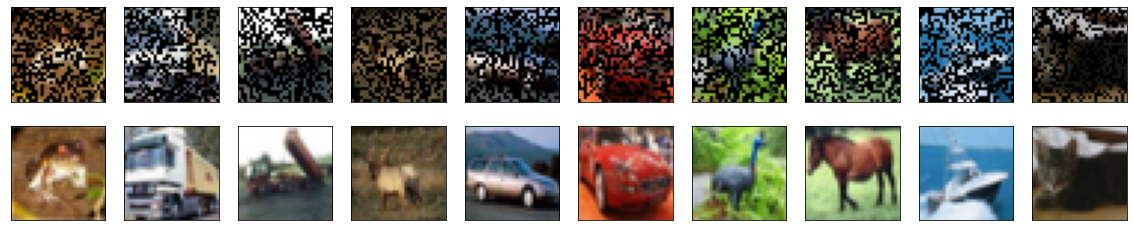

In [ ]:
# Function to visualize the noise added

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 4))
for i in range(0,10):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(x_train_noise[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
for i in range(0,10):
  ax=plt.subplot(2,10,i+11)
  plt.imshow(x_train[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


Convolutional Autoencoder

In [ ]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Flatten()(x)
x = Dense(3072)(x)
x = BatchNormalization()(x)
encoded = Activation('sigmoid')(x)

In [ ]:
x = Dense(3072)(encoded)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Reshape((32,32,3))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [ ]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
checkpoint_path = "checkpoints"
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = checkpoint_path + 'AutoEncoder_Cifar10_delineBlack_CAE_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
cp_callback =ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Training the Autoencoder

In [ ]:
history = model.fit(x_train_noise[:37500], x_train[:37500],
                    batch_size=50,
                    epochs=15,
                    verbose=1,
                    validation_data=(x_train_noise[37500:], x_train[37500:]),
                    callbacks=[cp_cb,es_cb],
                    shuffle=True)

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 130s 3ms/step - loss: 0.0066 - val_loss: 0.0046

Epoch 00001: val_loss improved from 0.00757 to 0.00456, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.01-0.01-0.00.hdf5
Epoch 2/15
37500/37500 [==============================] - 131s 3ms/step - loss: 0.0052 - val_loss: 0.0042

Epoch 00002: val_loss improved from 0.00456 to 0.00415, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.02-0.01-0.00.hdf5
Epoch 3/15
37500/37500 [==============================] - 130s 3ms/step - loss: 0.0048 - val_loss: 0.0039

Epoch 00003: val_loss improved from 0.00415 to 0.00390, saving model to checkpointsAutoEncoder_Cifar10_delineBlack_CAE_weights.03-0.00-0.00.hdf5
Epoch 4/15
37500/37500 [==============================] - 130s 3ms/step - loss: 0.0045 - val_loss: 0.0037

Epoch 00004: val_loss improved from 0.00390 to 0.00367, saving model to checkpointsAuto

In [ ]:
c10test = model.predict(x_test_noise)

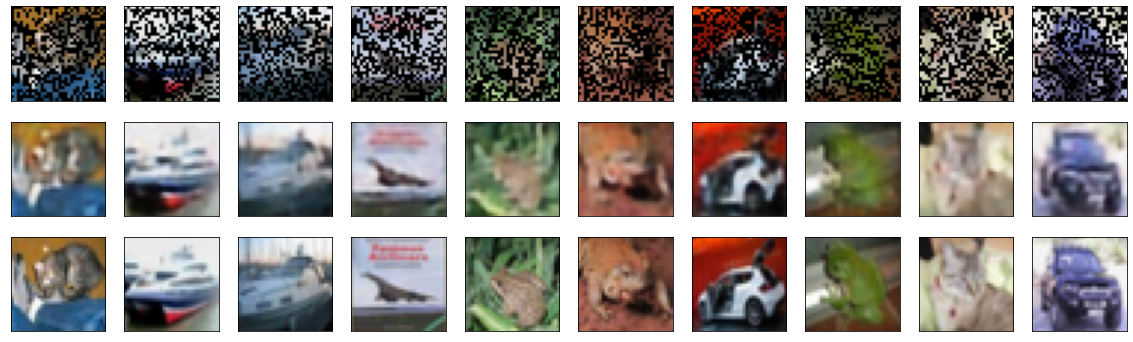

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(0,10):
  ax=plt.subplot(3,10,i+1)
  plt.imshow(x_test_noise[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
#for i in range(0,10):
#  ax=plt.subplot(2,10,i+11)
#  plt.imshow(x_train[i])
#  ax.get_xaxis().set_visible(False)
#  ax.get_yaxis().set_visible(False)
for i in range(0,10):
  ax=plt.subplot(3,10,i+11)
  plt.imshow(c10test[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

for i in range(0,10):
  ax=plt.subplot(3,10,i+21)
  plt.imshow(x_test[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)